# Example usage of the *phenom* library

This example notebook walks through an example usage of the *phenom* library, matching the analysis reported in the manuscript. Specifically, this example with cover the fixed effect modeling of a single treatment effect (oxidative stress on *H. salinarum*) as well as an extended model that considers batch effects.

Throughout, the number of time points is decreased relative to that in the manuscript to enable faster proof of concept inference. This sub-sampling can be removed to match the inference in the original paper. We have also only considered a subset of batches in the raw data for similar reasons.

## Environment initialization

In [23]:
import os
import pickle
import matplotlib.pyplot as plt

import phenom
from phenom import DataSet
from phenom.phenotype import Phenotype
from phenom.design import Formula

%matplotlib inline

## Dataset loading

First we load the data necessary to perform analysis, available in the `data` folder.

In [2]:
batch1 = DataSet.fromDirectory("../data/low-oxidative/20150517_PQ_3/")
batch2 = DataSet.fromDirectory("../data/low-oxidative/20150607_PQ_4/")
batch3 = DataSet.fromDirectory("../data/low-oxidative/20150702_PQ_6/")

### example structure of dataset

In [3]:
batch1.data.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
time,,,,,,,,,,,,,,,,,,,,,
0.0,0.094,0.096,0.099,0.096,0.101,0.098,0.091,0.093,0.095,0.096,...,0.111,0.105,0.136,0.121,0.118,0.112,0.111,0.106,0.106,0.103
0.5,0.094,0.095,0.097,0.097,0.100,0.097,0.091,0.092,0.094,0.094,...,0.107,0.104,0.136,0.122,0.119,0.112,0.110,0.102,0.105,0.101
1.0,0.095,0.096,0.098,0.099,0.103,0.101,0.093,0.094,0.096,0.095,...,0.108,0.106,0.142,0.130,0.123,0.116,0.113,0.104,0.106,0.103
1.5,0.095,0.097,0.098,0.100,0.105,0.102,0.093,0.094,0.097,0.096,...,0.109,0.108,0.147,0.134,0.127,0.119,0.116,0.104,0.107,0.104
2.0,0.096,0.098,0.099,0.101,0.107,0.104,0.095,0.095,0.098,0.097,...,0.111,0.110,0.152,0.139,0.132,0.123,0.120,0.107,0.109,0.107


In [4]:
batch1.meta.head()

,Unnamed: 0,Well,Strain,Bio,Tech,Media,Condition,Plate Age,mM PQ,plate
0,26,127,ura3,A,1.0,CM,NaN,23,0.0,20150517_PQ_3/
1,27,128,ura3,A,2.0,CM,NaN,23,0.0,20150517_PQ_3/
2,28,129,ura3,A,3.0,CM,NaN,23,0.0,20150517_PQ_3/
3,29,130,ura3,B,1.0,CM,NaN,23,0.0,20150517_PQ_3/
4,30,131,ura3,B,2.0,CM,NaN,23,0.0,20150517_PQ_3/


Text(0, 0.5, 'OD')

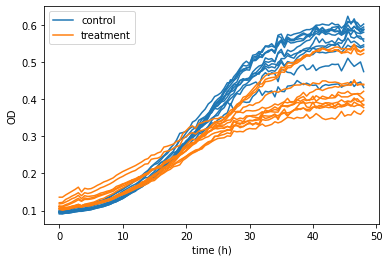

In [5]:
lines = plt.plot(batch1.data.loc[:, batch1.meta['mM PQ'] == 0], c="C0");
lines2 = plt.plot(batch1.data.loc[:, batch1.meta['mM PQ'] != 0], c="C1");
plt.legend(lines[:1]+lines2[:1], ["control", "treatment"])
plt.xlabel("time (h)")
plt.ylabel("OD")

### Data processing

In [3]:
# combine all batches into a single dataset
ds = batch1.concat(batch2).concat(batch3)

ds.log() # log the data

# remove spaces for formula specification
ds.meta['mMPQ'] = ds.meta['mM PQ']

# skip the early timepoints, 
# which usually have higher error,
# and subsample the observations
ds.data = ds.data.iloc[5::10, :]

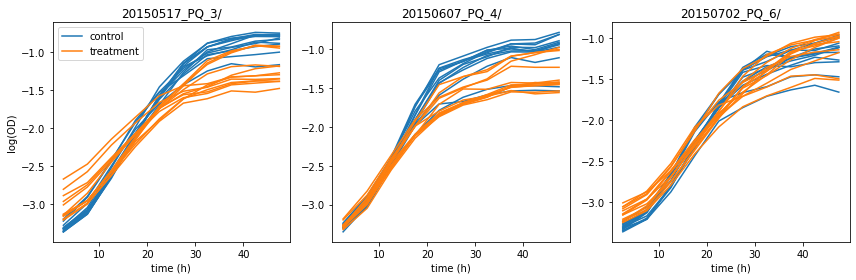

In [7]:
# plot all data after processing
plt.figure(figsize=(12, 4))
for i, batch in enumerate(ds.meta.plate.unique()):
    plt.subplot(1, 3, i+1)

    lines = plt.plot(ds.data.loc[:, (ds.meta.plate==batch) & (ds.meta['mM PQ'] == 0)], c="C0");
    lines2 = plt.plot(ds.data.loc[:, (ds.meta.plate==batch) & (ds.meta['mM PQ'] != 0)], c="C1");
    
    plt.xlabel("time (h)")
    plt.title(batch)
    
    if i == 0:
        plt.ylabel("log(OD)")
        plt.legend(lines[:1]+lines2[:1], ["control", "treatment"])
        
plt.tight_layout()

## Experimental design

To match the loaded dataset, we have to specify an experimental design that to inform the model what latent functions should be identified during inference. In the case of a single treatment effect, we estimate the fixed effect model (see manuscript for details):

$$y(t) = \mu(t) + \delta(t) + \epsilon(t)$$

This is done through the library `patsy` which uses a formula based method to describe linear model design matrices. This is provided through the formula interface in `phenom`.

In [16]:
fixed_effects = Formula(ds.meta, "C(mMPQ, Sum)")

fixed_effects.frame.head()

,Intercept,"C(mMPQ, Sum)[S.0.0]"
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0


We will also specify the mixed effects model that will combine to model the batch effects in the data

In [5]:
# adding formulas concatenates them
# we add a constant term with a plate specific effect to represent the fixed and random effects in the data
hierarchy = Formula(ds.meta, "1") + Formula(ds.meta, "C(plate) + 0")

mixed_effects = fixed_effects * hierarchy
mixed_effects.frame.head()

,(Intercept)x(Intercept),(Intercept)x(C(plate)[20150517_PQ_3/]),(Intercept)x(C(plate)[20150607_PQ_4/]),(Intercept)x(C(plate)[20150702_PQ_6/]),"(C(mMPQ, Sum)[S.0.0])x(Intercept)","(C(mMPQ, Sum)[S.0.0])x(C(plate)[20150517_PQ_3/])","(C(mMPQ, Sum)[S.0.0])x(C(plate)[20150607_PQ_4/])","(C(mMPQ, Sum)[S.0.0])x(C(plate)[20150702_PQ_6/])"
0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
2,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
3,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
4,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


Each term in the `patsy` formula specifies a group of functions to estimate (e.g. each level of a treatment effect), which are grouped by a shared GP prior. The number of prior groups is accessible through the `L` property of each design:

In [6]:
fixed_effects.L, mixed_effects.L

(2, 4)

You can also see the assignment of different functions to various priors through the `priors` attribute. This is useful for specifying hyper-priors before inference:

In [7]:
mixed_effects.priors

array([0, 2, 2, 2, 1, 3, 3, 3])

## Phenotype inference

Now we combine the dataset and design to construct a `phenotype` object, which is then used to perform statistical inference. This is also where we specify hyper-priors for the groups of GP hyperparameters for fixed and random effects in the model. We use the hyper-priors equivalent to those in the manuscript.

In [8]:
mnull = Phenotype(ds.data, fixed_effects)

mbatch = Phenotype(ds.data, mixed_effects,
                   alpha_priors=[[6, 1], [6, 1], [6, 1], [6, 1]], 
                   lengthscale_priors=[[10.0, 10.0], [10.0, 10.0], [7.0, 10.0], [7.0, 10.0]],
                   minExpectedCross=0.1, # min/max expected cross constrain the lengthscale to lie within a certain range
                   maxExpectedCross=3,
                   sigma_prior=[0.02, 20],)

mfull = Phenotype(ds.data, mixed_effects,
                  model="phenom_marginal.stan",
                  alpha_priors=[[6, 1], [6, 1], [6, 1], [6, 1]], 
                  lengthscale_priors=[[10.0, 10.0], [10.0, 10.0], [7.0, 10.0], [7.0, 10.0]],
                  minExpectedCross=0.1, # min/max expected cross constrain the lengthscale to lie within a certain range
                  maxExpectedCross=3,
                  sigma_prior=[0.02, 20],)

Now we perform statistical inference. First, the stan model is compiled, and then MCMC is run. This is where the bulk of computational time will be spent. We again simplify computation in this example by reducing the number of samples generated from the markov chain (200) compared to the typical 1000 samples generated for each chain. We also provide parameters to control other factors of the model inference (e.g. adapt_delta) that are documented in the `pystan` library.

In [9]:
null_samples = mnull.samples(iter=1200, warmup=1000, control=dict(adapt_delta=.97, max_treedepth=20))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b94a1a41f39d75712eac6284f5183d7d NOW.


In [11]:
mnull.save("example/mnull")

In [10]:
batch_samples = mbatch.samples(iter=1200, warmup=1000, control=dict(adapt_delta=.97, max_treedepth=20))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b94a1a41f39d75712eac6284f5183d7d NOW.


In [12]:
mbatch.save("example/mbatch")

In [13]:
full_samples = mfull.samples(iter=1200, warmup=1000, control=dict(adapt_delta=.97, max_treedepth=20))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cdfdbe27d922eccd60f151f4bc0e2643 NOW.


In [14]:
mfull.save("example/mfull")

## Model evaluation

Now we evaluate the posterior estimates of the treatment effect, $\delta(t)$, under each model. We use a built-in function interval plotting function from `phenom`. Note, the -2 multiplicative factor represents the correction of directionality in the fixed effects model, as well as the relative difference induced by the effect in the design matrix (1 - (-1) = 2).

As we see below, with fewer batches to estimate the low oxidative treatment effect, the treatment is not significant under Mbatch or Mfull.

In [32]:
null_samples = pickle.load(open("example/mnull/samples/posterior_0.pkl", "rb"))
batch_samples = pickle.load(open("example/mbatch/samples/posterior_0.pkl", "rb"))
full_samples = pickle.load(open("example/mfull/samples/posterior_0.pkl", "rb"))

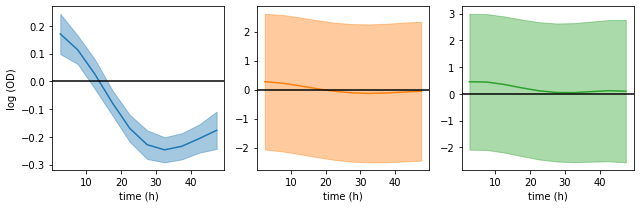

In [59]:
plt.figure(figsize=(9, 3))

plt.subplot(131)
phenom.plot.function.interval(ds.data.index, -2*null_samples['f-native'][:, 1, :])
plt.axhline(0, c="k")
plt.ylabel("log (OD)")
plt.xlabel("time (h)")

# the treatment fixed effect is at index 4 for these models
plt.subplot(132)
phenom.plot.function.interval(ds.data.index, -2*batch_samples['f-native'][:, 4, :], color="C1")
plt.axhline(0, c="k")
plt.xlabel("time (h)")

plt.subplot(133)
phenom.plot.function.interval(ds.data.index, -2*full_samples['f-native'][:, 4, :], color="C2")
plt.axhline(0, c="k")
plt.xlabel("time (h)")

plt.tight_layout()